Predictor Bot : Predicting Crypto Prices for the next 10 candles on the 3 minute chart using LSTM 

In [34]:
#Packages Import
import math # Mathematical functions 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

In [2]:
pip install python-binance

     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 1.1 MB 30.8 MB/s 
     |████████████████████████████████| 216 kB 67.0 MB/s 
     |████████████████████████████████| 103 kB 49.8 MB/s 
     |████████████████████████████████| 288 kB 72.8 MB/s 
     |████████████████████████████████| 271 kB 82.4 MB/s 
     |████████████████████████████████| 192 kB 58.9 MB/s 
     |████████████████████████████████| 160 kB 54.8 MB/s 


In [4]:
from datetime import datetime
from pandas_datareader.data import DataReader

In [35]:
# Data retrieval for cryptocurrencies BTCUSDT ETHUSDT XMRUSDT 
# Binance API credentials 
apikey = '2ZaEiNukiFtPHqnYdCGMANNimHdcCF0nvv4L9eYXMIdr4ovveQrca4NWKsZ7DxAy'
secretkey = '9zjousoyG0t2wblcGkm0tVGLBfz6Woo3paakGh49Vhj0IxrGGXl332b1KQaxlJKY'

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
#API Initialization 
client = Client(apikey, secretkey)

In [6]:
import pickle 

df = pd.read_pickle('BTCUSDT_3MIN')
#Checking that it is a DF before moving one
type(df)

pandas.core.frame.DataFrame

In [7]:
# Indexing Batches


df_train = df.sort_values(by=['Open Time']).copy()

# Saving a copy of the dates index, before we need to reset it to numbers
date_index = df_train.index

# We reset the index, so we can convert the date-index to a number-index
# df_train = df_train.reset_index(drop=True).copy()
df_train.drop(columns=['index'], inplace=True, axis = 1)
df_train.tail(5)

,Open Time,Open,High,Low,Close,Volume,Close Time,Nb of Trade
1638316080000,1638316080000,56963.07000000,56989.16000000,56839.74000000,56843.19000000,121.60075000,1638316259999,3237
1638316260000,1638316260000,56850.01000000,57053.90000000,56762.39000000,57046.04000000,171.24335000,1638316439999,4405
1638316440000,1638316440000,57046.05000000,57054.09000000,56967.15000000,57000.01000000,57.74293000,1638316619999,1645
1638316620000,1638316620000,57000.01000000,57012.20000000,56835.92000000,56950.56000000,55.53555000,1638316799999,1864
1638316800000,1638316800000,56950.56000000,57011.08000000,56650.00000000,56667.73000000,218.73433000,1638316979999,5330


In [8]:
def prepare_data(df):

    # List of considered Features
    FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    df_filter = df[FEATURES]
    
    # Convert the data to numpy values
    np_filter_unscaled = np.array(df_filter)
    #np_filter_unscaled = np.reshape(np_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)

    np_c_unscaled = np.array(df['Close']).reshape(-1, 1)
    
    return np_filter_unscaled, np_c_unscaled
    
np_filter_unscaled, np_c_unscaled = prepare_data(df_train)
                                          
# Creating a separate scaler that works on a single column for scaling predictions
# Scale each feature to a range between 0 and 1

scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)   
print(np_scaled)

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Volume']
(87711, 5)
[[0.20800078 0.20960274 0.20838756 0.21300892 0.06822716]
 [0.21296847 0.21484945 0.21652886 0.21735838 0.20644404]
 [0.2173184  0.21399901 0.21850145 0.2166341  0.03674279]
 ...
 [0.70542884 0.70067    0.70749145 0.70428701 0.01061661]
 [0.70427174 0.69962036 0.70419468 0.70304427 0.01016149]
 [0.70302894 0.6995923  0.69952399 0.69593641 0.04380963]]


(70109, 50, 5) (70109, 10)
(17532, 50, 5) (17532, 10)


<function matplotlib.pyplot.show(close=None, block=None)>

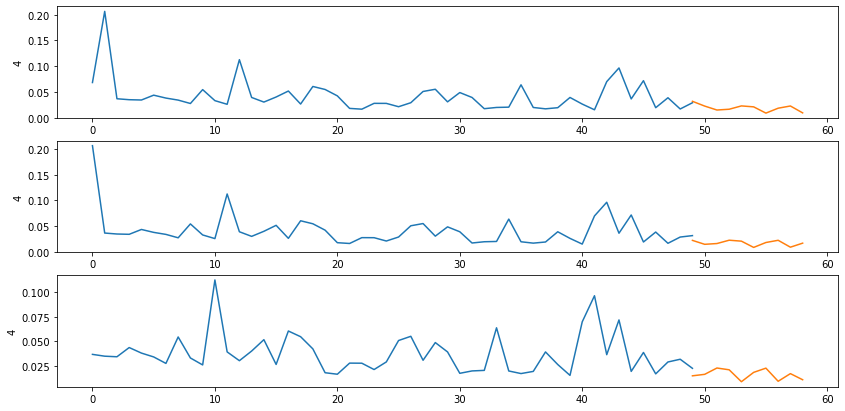

In [9]:
# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 50
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 10 #

# Prediction Index
index_Close = df_train.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_scaled[0:train_data_length, :]
test_data = np_scaled[train_data_length - input_sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, input_sequence_length time steps per sample, and f features
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) 
        y.append(data[i:i + output_sequence_length, index_Close]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(14, 7))
for i in range(nrows):
    sns.lineplot(y = pd.DataFrame(x_train[i])[index_Close], x = range(input_sequence_length), ax = ax[i])
    sns.lineplot(y = y_train[i], x = range(input_sequence_length -1, input_sequence_length + output_sequence_length - 1), ax = ax[i])
plt.show

Model Training 

In [10]:
# Configure the neural network model
model = Sequential()
n_output_neurons = output_sequence_length

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_input_neurons = x_train.shape[1] * x_train.shape[2]
print(n_input_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_input_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(n_output_neurons))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


No handles with labels found to put in legend.


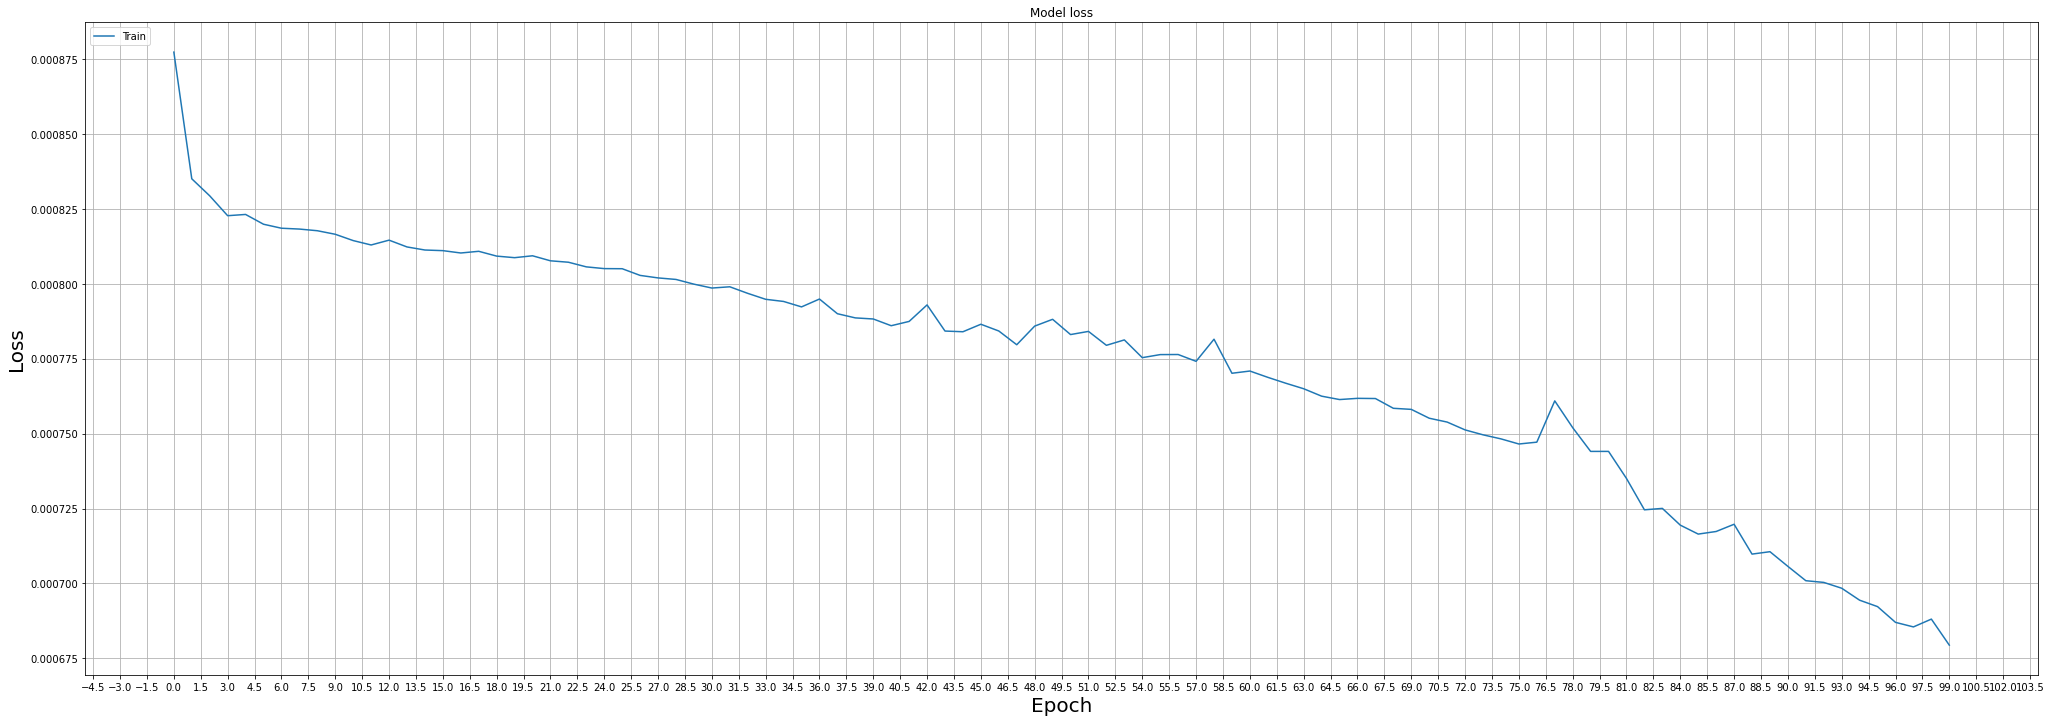

In [24]:
# Plot training & validation loss values

# Loading previously saved history from our BTCUSDT 3MIN model with 100 epoch batchsize 64:

history=np.load('my_history.npy',allow_pickle='TRUE').item()

epochs = 100 

fig, ax = plt.subplots(figsize=(35, 12), sharex=True)
plt.plot(history["loss"])
plt.title("Model loss")
plt.ylabel("Loss", fontsize = 20)
plt.xlabel("Epoch", fontsize = 20)
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(fontsize=35)
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

Model Performance Evaluation    

In [13]:
pip install tf

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tf: filename=tf-1.0.0-py3-none-any.whl size=1290 sha256=b7b7578ea5875e46ff12480508b2e2c21d8a98eacad999157c10e7fd7e3e4176
  Stored in directory: c:\users\fluffy\appdata\local\pip\cache\wheels\2c\6e\f8\1e3b5bd4457a9ca1240eb36a4799a0a4a24db275ba5f787a24
Successfully built tf
Note: you may need to restart the kernel to use updated packages.


import pickle
from tensorflow import keras
model = keras.models.load_model('Models\BTC_Model_3MIN.h5')

In [25]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
y_test_unscaled.shape

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 418.6
Mean Absolute Percentage Error (MAPE): 1.36 %
Median Absolute Percentage Error (MDAPE): 0.93 %


Multi Test Forecast

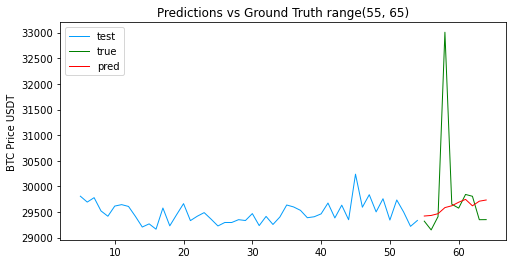

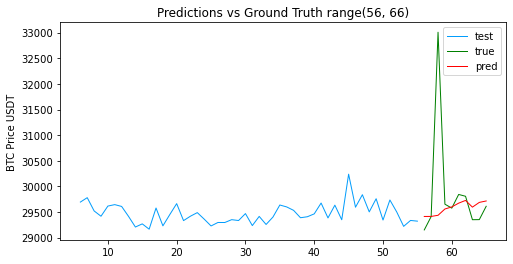

In [20]:
def plot_multi_test_forecast(i, s, x_test, y_test_unscaled, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
    df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
    test_max_index = df_test.shape[0]
    pred_max_index = y_pred_unscaled[0].shape[0]
    test_index = range(i, i + test_max_index)
    pred_index = range(i + test_max_index, i + test_max_index + pred_max_index)
    
    # package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true
    data = pd.DataFrame(list(zip(y_pred_unscaled[s], y_test_unscaled[i])), columns=['pred', 'true']) #
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
    ax.set(ylabel =  "BTC Price USDT")
    
    sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
    sns.lineplot(data = data,  y='true', x=pred_index, color="g", linewidth=1.0, label='true')
    sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')

x_test_unscaled = scaler_pred.inverse_transform(np.array(pd.DataFrame(x_test[0])[index_Close]).reshape(-1, 1)) 
df_test = pd.DataFrame(x_test_unscaled)
    
for i in range(5, 7): #i is the starting point for the batch in the time-series
    #data = pd.DataFrame(list(zip(y_pred[i], y_test_unscaled[i])), columns=['pred', 'true'], index=range(55,65))
    plot_multi_test_forecast(i, i, x_test, y_test_unscaled, y_pred)

New Forecast 

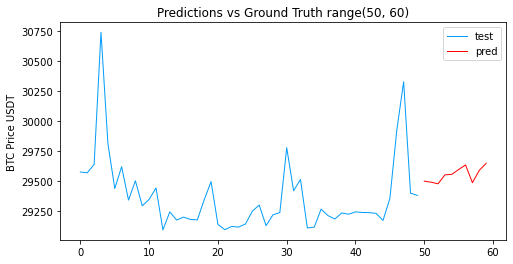

In [21]:
def plot_new_multi_forecast(i_test, i_pred, x_test, y_pred_unscaled): 
    
    # reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_scaled_reshaped = np.array(pd.DataFrame(x_test[i_test])[index_Close]).reshape(-1, 1)
    
    # undo the scaling on the testset
    df_test = pd.DataFrame(scaler_pred.inverse_transform(x_test_scaled_reshaped) )

    # set the max index 
    test_max_index = df_test.shape[0]
    pred_max_index = y_pred_unscaled[0].shape[0]
    test_index = range(i_test, i_test + test_max_index)
    pred_index = range(i_test + test_max_index, i_test + test_max_index + pred_max_index)
    
    data = pd.DataFrame(list(zip(y_pred_unscaled[i_pred])), columns=['pred']) #
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(f"Predictions vs Ground Truth {pred_index}", fontsize=12)
    ax.set(ylabel =  "BTC Price USDT")
    
    sns.lineplot(data = df_test,  y = df_test[0], x=test_index, color="#039dfc", linewidth=1.0, label='test')
    sns.lineplot(data = data,  y='pred', x=pred_index, color="r", linewidth=1.0, label='pred')
    
# get the highest index from the x_test dataset
index_max = x_test.shape[0]
x_test_new = np_scaled[-51:-1,:].reshape(1,50,5)

# undo the scaling of the predictions
y_pred_scaled = model.predict(x_test_new)
y_pred = scaler_pred.inverse_transform(y_pred_scaled)

# plot the predictions
plot_new_multi_forecast(0, 0, x_test_new, y_pred)

In [31]:
#Actual Prediction

#Packages to load previously scaled data in array format for each crypto prediction in the below if statements
# load numpy array from npy file
import keras
from numpy import load

def prediction(crypto):
  #Choose between BTCUSDT ETHUSDT XMRUSDT
  if crypto == "BTCUSDT":
    #Fetch Last Day 3min Candles Data
    klines = client.get_historical_klines(crypto, Client.KLINE_INTERVAL_3MINUTE, "1 day ago UTC")

    pred_df = pd.DataFrame(klines)
    pred_df.columns = (['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume','Nb of Trade', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume','Ignored'])
    # hist_df.drop(labels = ['TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignored', 'Quote Asset Volume'], inplace = True,axis = 1)
    pred_df['Close Time'] = pd.to_datetime(pred_df['Close Time']/1000, unit='s')
    # hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
    pred_df.drop(['Ignored', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Quote Asset Volume'], inplace= True, axis = 1)

    #load scaled xmr array
    np_scaled = load('scaled\btc_np_scaled.npy')

    pred_df = pred_df.apply(pd.to_numeric)
    pred = np_scaled[-51:-1,:].reshape(1,50,5)

    # pred_df.to_csv('5H_avg_pred_df')
    # pred_df
    model = keras.models.load_model('Models\BTC_Model_3MIN.h5')
    btc_y_pred_scaled = model(pred)
    btc_y_pred = scaler_pred.inverse_transform(btc_y_pred_scaled)

    print(btc_y_pred)

  elif crypto == "XMRUSDT":

    #Fetch Last Day 3MINUTE Candles Data
    klines = client.get_historical_klines(crypto, Client.KLINE_INTERVAL_3MINUTE, "1 day ago UTC")

    pred_df = pd.DataFrame(klines)
    pred_df.columns = (['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume','Nb of Trade', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume','Ignored'])
    # hist_df.drop(labels = ['TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignored', 'Quote Asset Volume'], inplace = True,axis = 1)
    pred_df['Close Time'] = pd.to_datetime(pred_df['Close Time']/1000, unit='s')
    # hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
    pred_df.drop(['Ignored', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Quote Asset Volume'], inplace= True, axis = 1)

    #load scaled xmr array
    np_scaled = load('scaled\xmr_np_scaled.npy')

    xmr_pred_df = pred_df.apply(pd.to_numeric)
    xmr_pred = np_scaled[-51:-1,:].reshape(1,50,5)

    # pred_df.to_csv('5H_avg_pred_df')
    # pred_df
    xmr_model = keras.models.load_model('Models\XMR_Model_3MIN.h5')
    xmr_y_pred_scaled = xmr_model(xmr_pred)
    xmr_y_pred = scaler_pred.inverse_transform(xmr_y_pred_scaled)

    print(xmr_y_pred)
      
  elif crypto == "ETHUSDT":
    #Fetch Last Day  3min Candles Data
    klines = client.get_historical_klines(crypto, Client.KLINE_INTERVAL_3MINUTE, "1 day ago UTC")

    pred_df = pd.DataFrame(klines)
    pred_df.columns = (['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume','Nb of Trade', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume','Ignored'])
    # hist_df.drop(labels = ['TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Ignored', 'Quote Asset Volume'], inplace = True,axis = 1)
    pred_df['Close Time'] = pd.to_datetime(pred_df['Close Time']/1000, unit='s')
    # hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time']/1000, unit='s')
    pred_df.drop(['Ignored', 'TakerBuyBaseVolume', 'TakerBuyQuoteVolume', 'Quote Asset Volume'], inplace= True, axis = 1)
    # hist_df['Open Time'] = hist_df.index

    #load scaled xmr array
    np_scaled = load('scaled\eth_np_scaled.npy')
    eth_pred_df = pred_df.apply(pd.to_numeric)
    eth_pred = np_scaled[-51:-1,:].reshape(1,50,5)

    eth_model = keras.models.load_model('Models\ETH_Model_3MIN.h5')
    eth_y_pred_scaled = eth_model(eth_pred)
    eth_y_pred = scaler_pred.inverse_transform(eth_y_pred_scaled)

    print(eth_y_pred)


In [32]:
prediction("XMRUSDT")

[[29792.24667647 29763.1527225  29804.78264253 29690.46934874
  29637.54588245 29741.86712085 29710.79424852 29677.83836496
  29734.18528589 29753.98143648]]
